<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [19]:
from datetime import datetime

from helpers_image import show
from helpers_config import load_config, save_config
from unet import UNet

In [20]:
config = load_config()#path="../output/unet/config.json")
#dir_name = datetime.today().strftime("%Y%m%d_%H%M%S")
save_dir = config['dst_path'] + config['model_name'] + "/"

save_dir

'../output/unet/'

In [21]:
pipeline = UNet(data_dir=config['data_dir'],
                grayscale=config['grayscale'],
                initial_epoch=config['initial_epoch'],
                tr_losses=config['tr_losses'],
                val_losses=config['val_losses'])

In [22]:
X_tr, Y, X_te = pipeline.load_data(patch_size=config['patch_size'],
                                   stride=config['stride'],
                                   normalized=config['normalized'],
                                   gamma=config['gamma'],
                                   clahe=config['clahe'],
                                   rotations=config['rotations'],
                                   sample_tr_img=config['sample_tr_img'],
                                   sample_te_img=config['sample_te_img'])

loading data...
(400, 400, 400, 1)
(400, 400, 400, 1)
(200, 608, 608, 1)
data loaded


In [23]:
X_tr.shape, Y.shape, X_te.shape

((176400, 80, 80, 1), (176400, 80, 80, 1), (231200, 80, 80, 1))

In [24]:
i = 
show([X_tr[i], Y[i]])

SyntaxError: invalid syntax (<ipython-input-24-e55a5966a591>, line 1)

In [ ]:
'''
pipeline.train_model(X_tr=X_tr,
                     Y=Y,
                     epochs=config['epochs'],
                     sample_img=config['sample_tr_size'],
                     batch_size=config['batch_size'],
                     verbose=config['verbose'],
                     validation_split=config['validation_split'],
                     shuffle=config['shuffle'],
                     load_checkpoint=config['load_checkpoint'],
                     checkpoint_path=save_dir,
                     save_best_only=config['save_best_only'])
'''
pipeline.load_model(save_dir + 'weights.hdf5')

In [ ]:
pipeline.initial_epoch

In [ ]:
pipeline.val_losses

In [16]:
predictions = pipeline.predict(X_te=X_te[:34*34*1], sample_img=config['sample_te_img'], batch_size=400)

1156/1156 [==============================] - 194s 168ms/step


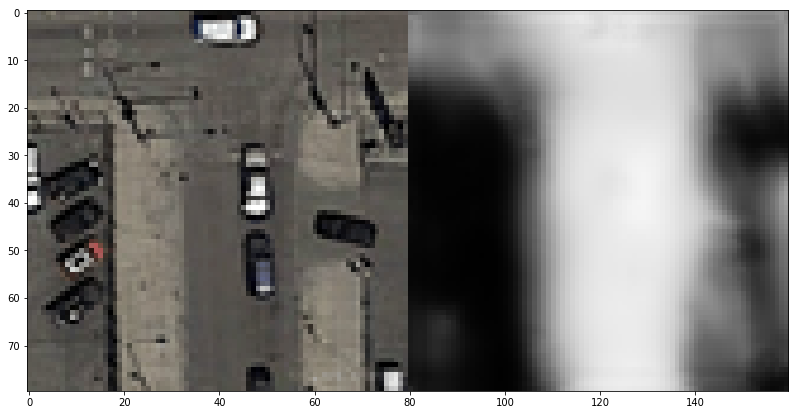

In [18]:
i = 91
show([X_te[i], predictions[i]])

In [19]:
Y_tr = pipeline.predict(X_tr[:10], sample_img=5, batch_size=10)

10/10 [==============================] - 2s 177ms/step


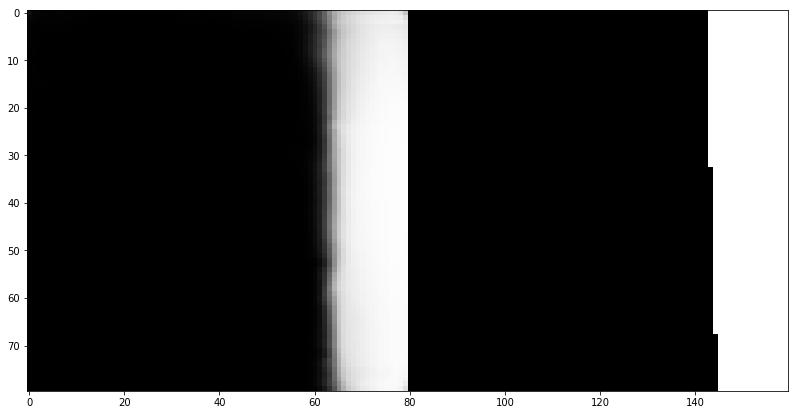

In [127]:
i = 8
show([Y_tr[i], Y[i]])

In [16]:
pipeline.save_output(predictions, save_dir, config.copy())

In [119]:
def patches_to_img(patches, stride, img_shape):
    if len(img_shape) > 2:
        channels = [patches_to_img(patches[:, :, :, i], stride, img_shape[:2]) for i in range(3)]
        return np.concatenate(channels, axis=2)

    h, w = img_shape
    patch_size = patches.shape[1]
    n_stride = (h - patch_size) // stride + 1

    assert h == w, "only squared image are accepted"
    assert (h - patch_size) % stride == 0, "The stride must be adapted on image and patch size"
    assert len(patches) % n_stride ** 2 == 0, "They must be the right number of patches per image"

    pred_final = np.zeros(img_shape + (1,))  # Accumulator for the final prediction
    pred_normalizer = np.zeros(img_shape + (1,))  # Counter of the patch per prediction per pixel

    for i in range(n_stride):
        for j in range(n_stride):
            x_from, x_to = i * stride, i * stride + patch_size
            y_from, y_to = j * stride, j * stride + patch_size
            idx = i * n_stride + j
            pred_final[x_from: x_to, y_from: y_to] += patches[idx].reshape(patch_size, patch_size, 1)
            pred_normalizer[x_from: x_to, y_from: y_to] += 1
    return pred_final / pred_normalizer

In [120]:
img = patches_to_img(predictions, stride=config['stride'], img_shape=(pipeline.te_h, pipeline.te_w))

608 608 80 34


In [121]:
predictions.shape

(1156, 80, 80, 1)

In [122]:
X_te[0][:, :, 2].shape

(80, 80)

In [123]:
patches_to_img(X_te[34*34*i:34*34*(i+1)], 16, (608, 608, 3)).shape

608 608 80 34
608 608 80 34
608 608 80 34


(608, 608, 3)

608 608 80 34
608 608 80 34
608 608 80 34


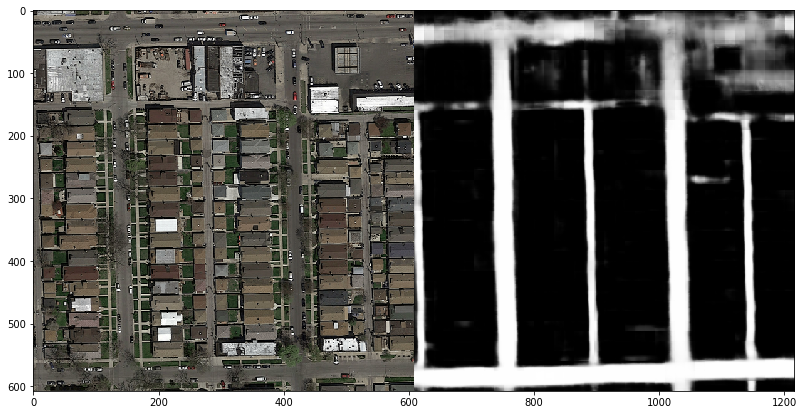

In [124]:
i=0
show([combine_prediction2(X_te[34*34*i:34*34*(i+1)], 16, (608, 608, 3)), img])